In [67]:
import sys

sys.path.append('..')
import numpy as np
import chess, chess.pgn
from utils import evaluate_board, parse_board_12, parse_board_6

In [102]:
path = '../data/carlsen_niemann.pgn'
pgn = open(path)
game = chess.pgn.read_game(pgn)

moves_12 = np.zeros((60, 12, 8, 8))
moves_6 = np.zeros((60, 6, 8, 8))
evals = np.zeros((60))

board = game.board()
for i, move in enumerate(game.mainline_moves()):
  board.push(move)
  if i > 10 and i < 70:
    moves_12[i - 10] = parse_board_12(board)
    moves_6[i - 10] = parse_board_6(board)
    evals[i - 10] = evaluate_board(board)

In [101]:
# Set up attention extraction
class SaveOutput:
  def __init__(self):
    self.outputs = []

  def __call__(self, module, module_in, module_out):
    self.outputs.append(module_out[1][:, :, :-1, :-1])

  def clear(self):
    self.outputs = []


# Patch attention to always output weights explicitly
def patch_attention(m):
  forward_orig = m.forward

  def wrap(*args, **kwargs):
    kwargs['need_weights'] = True
    kwargs['average_attn_weights'] = False
    return forward_orig(*args, **kwargs)

  m.forward = wrap

In [161]:
import torch
import torch.nn.functional as F
from model import Transformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 6

weights_path = f'../temp/weights/Transformer(evals)_generated_{channels}_10000_60_0.5_64_0.0005_0.0001_20.pt'
model = Transformer(channels=channels, num_moves=60, evals=True, times=False)
model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
model.to(device)
model.eval()
save_output = SaveOutput()
patch_attention(model.transformer_encoder.layers[-1].self_attn)
hook_handle = model.transformer_encoder.layers[-1].self_attn.register_forward_hook(save_output)

m_tensor = torch.tensor(moves_12 if channels == 12 else moves_6, dtype=torch.float32).unsqueeze(0).to(device)
e_tensor = torch.tensor(evals, dtype=torch.float32).unsqueeze(0).to(device)


with torch.no_grad():
  output = model(moves=m_tensor, evals=e_tensor)
  preds = F.softmax(output, dim=1)
  print(preds)

hook_handle.remove()

tensor([[0.0203, 0.0242, 0.0449, 0.9105]], device='cuda:0')


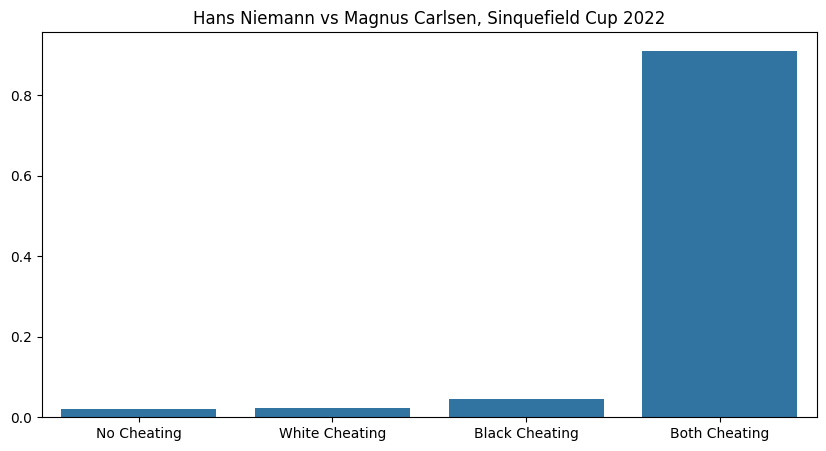

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# bar preds
# labels = [noone cheating, white cheating, black cheating, both cheating]
plt.figure(figsize=(10, 5))
plt.title('Hans Niemann vs Magnus Carlsen, Sinquefield Cup 2022')
sns.barplot(x=['No Cheating', 'White Cheating', 'Black Cheating', 'Both Cheating'], y=preds[0].cpu().numpy())
plt.show()

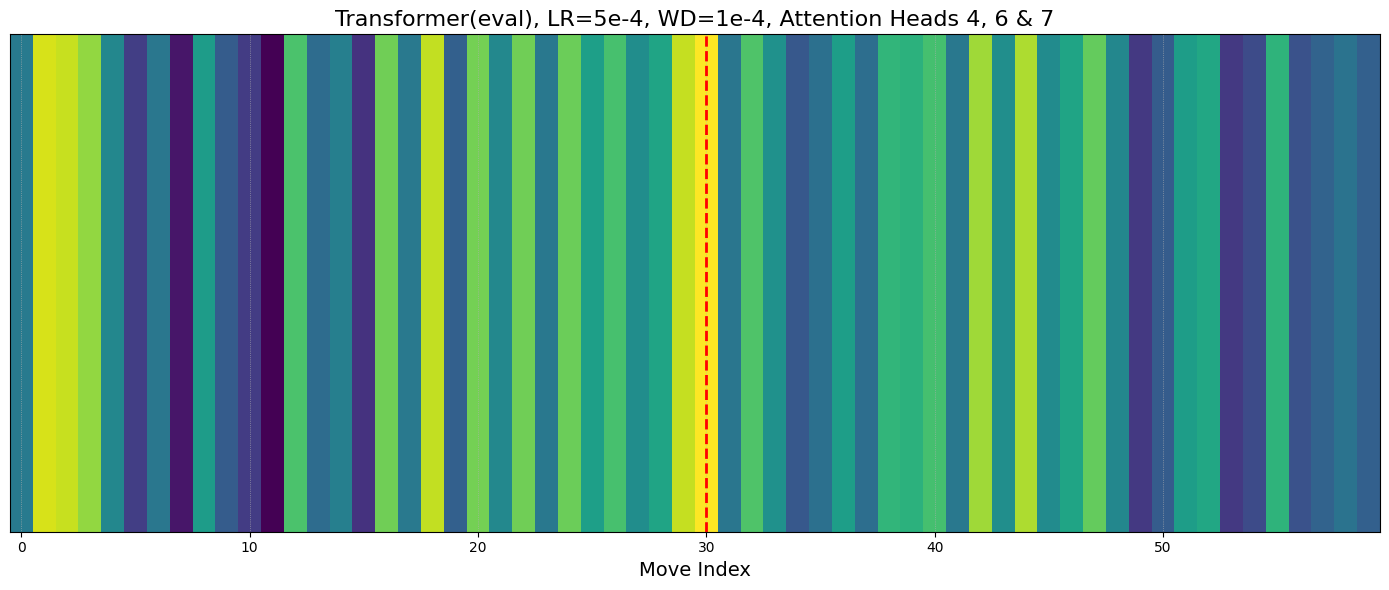

In [170]:
plt.figure(figsize=(14, 6))
plt.imshow(best_vector[np.newaxis, :], cmap='viridis', aspect='auto')
plt.yticks([])
plt.xlabel('Move Index', fontsize=14)

# Mark the suspicious move (index 30)
plt.axvline(x=suspicious_move_index, color='red', linestyle='--', linewidth=2, label='Suspicious Move')

plt.title(f'Transformer(eval), LR=5e-4, WD=1e-4, Attention Heads 4, 6 & 7', fontsize=16)
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()